In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.nn import functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set(color_codes=True)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import h5py
import cv2
from scipy.stats import pearsonr#Pearson correlation coefficient
from sklearn.decomposition import randomized_svd
from scipy.signal import find_peaks
import scipy.optimize as opt

#import tensorly as tl#use tensorly to do tensor decompostion
#from tensorly.decomposition import parafac
#tl.set_backend('numpy') # or any other backend

import datetime
import time
#import winsound#sound alarm when code finishes, only in windows

#import pytorch_ssim

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(1)

torch.backends.cudnn.deterministic=True
np.random.seed(1)
torch.manual_seed(1)    # reproducible

In [3]:
# for plot figures
plt.rcParams.update({'figure.max_open_warning': 0})
#Output matplotlib figure to SVG with text as text, not curves
plt.rcParams['svg.fonttype'] = 'none'
# axis spine
#use it like: adjust_spines(ax, ['left', 'bottom'])
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 2))  # outward by 2 points
            #spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine
    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [4]:
training_inputs = np.load('../data/fig3_training_inputs.npy')
training_set = np.load('../data/fig3_training_set.npy')
test_inputs = np.load('../data/fig3_test_inputs.npy')
test_set = np.load('../data/fig3_test_set.npy')
movie_bgr_h5 = np.load('../data/fig3_movie_bgr_h5.npy')

In [5]:
#split original training data into two parts, training loader: 2200, validation loader: 200
#make the dataset suitable for pytorch
train_loader=[]
for ii in range(0,2200,110):
    temp0=training_inputs[ii:ii+110] -0.5 #center the stimulus
    temp1=training_set[ii:ii+110]#100*200(neurons)
    temp=(temp0,temp1)
    train_loader.append(temp)

temp0=training_inputs[2200:] -0.5 #center the stimulus
temp1=training_set[2200:]#200*200(neurons)
val_loader=(temp0,temp1)

temp0=np.copy(test_inputs) -0.5 #center the stimulus
temp1=np.copy(test_set)#50*200(neurons)
test_loader=(temp0,temp1)

print ('length of train_loader:')
print (len(train_loader))
print ('shape of train_loader[0][0]:')
print (train_loader[0][0].shape)
print ('shape of train_loader[0][1]:')
print (train_loader[0][1].shape)
print ('shape of val_loader[0]:')
print (val_loader[0].shape)
print ('shape of val_loader[1]:')
print (val_loader[1].shape)
print ('shape of test_loader[0]:')
print (test_loader[0].shape)
print ('shape of test_loader[1]:')
print (test_loader[1].shape)

length of train_loader:
20
shape of train_loader[0][0]:
(110, 2, 8, 28, 28)
shape of train_loader[0][1]:
(110, 96)
shape of val_loader[0]:
(200, 2, 8, 28, 28)
shape of val_loader[1]:
(200, 96)
shape of test_loader[0]:
(50, 2, 8, 28, 28)
shape of test_loader[1]:
(50, 96)


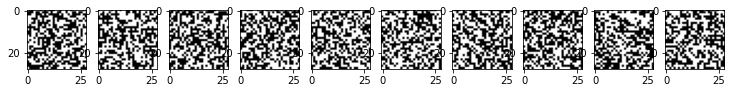

In [6]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(train_loader[0][0][ii][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

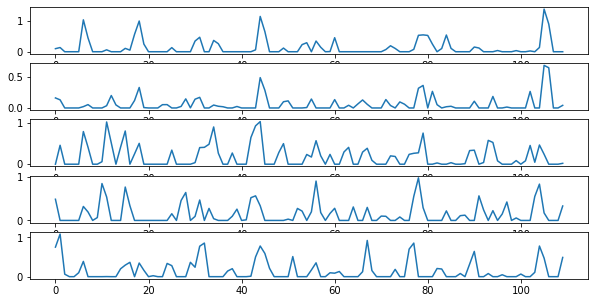

In [7]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(train_loader[0][1][:,ii])

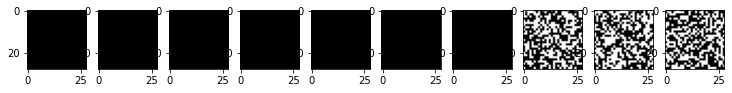

In [8]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(test_loader[0][ii][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

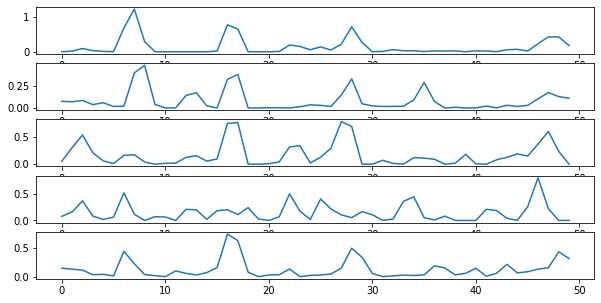

In [9]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(test_loader[1][:,ii])
    #axes[ii].grid(False)#axes[ii,jj].axis('tight')

In [10]:
#define train_loader_length and val_loader_length for function model_train()
train_loader_length=len(train_loader)
val_loader_length=len(val_loader[0])

In [11]:
#some help function
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

class Flatten3D(nn.Module):
    def forward(self, x):
        N, C, D, H, W = x.size() # read in N, C, D, H, W
        return x.view(N, -1)  # "flatten" the C *D* H * W values into a single vector per image

class Unflatten3D(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*D*H*W) and reshapes it
    to produce an output of shape (N, C, D,H, W).
    """
    def __init__(self, N=-1, C=128, D=7, H=7, W=7):
        super(Unflatten3D, self).__init__()
        self.N = N
        self.C = C
        self.D = D
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.D, self.H, self.W)
    
    
def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)
def init_weights_Kaiming(m):
    if type(m) == nn.Linear or type(m) == nn.Conv3d or type(m) == nn.ConvTranspose3d\
    or type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        #torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.kaiming_uniform_(m.weight)

def loss_vae(recon_x, x, mu, logvar):
    tempN=x.shape[0]
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #return BCE + KLD
    return (MSE + KLD)/(tempN*10*2*56*56)#batch size tempN, to be comparable with other ae variants loss

loss_mse = nn.MSELoss()
#loss_ssim = pytorch_ssim.SSIM(window_size=3)

#loss with L2 and L1 regularizer
#something like loss = mseloss+ alpha*alpha_x(L2)+beta*beta_y(L1), here alpha_x is a list of model layers
def loss_L2L1(recon_x, x, alpha, beta, alpha_x, beta_y):
    tempN=x.shape[0]
    MSE = F.mse_loss(recon_x, x,reduction='sum')
    l2temp=0.0
    for temp in alpha_x:
        l2temp = l2temp+ temp.weight.norm(2)
    L2loss=alpha*l2temp
    L1loss=beta*F.l1_loss(beta_y,torch.zeros_like(beta_y),reduction='sum')
    return (MSE+L2loss+L1loss)/(tempN*10*2*56*56)#batch size tempN, to be comparable with other ae variants loss

#loss with L2 and L1 regularizer, version2
#something like loss = mseloss+ alpha*alpha_x(L2)+beta*beta_y(L1), here alpha_x is a list of model layers
def loss_L2L1v2(recon_x, x, alpha, beta, alpha_x, beta_y):
    tempB, tempC, tempD, tempH, tempW =x.size()
    MSE = F.mse_loss(recon_x, x,reduction='sum')
    l2temp=0.0
    for temp in alpha_x:
        l2temp = l2temp+ temp.weight.norm(2)
    L2loss=alpha*l2temp
    B, C, D, H, W = beta_y.size() # Batch*channel*depth*height*width
    temp1=beta_y.view(B,C,-1)
    temp2=torch.norm(temp1,p=2,dim=2)
    temp3=torch.sum(torch.abs(temp2))
    L1loss=beta*temp3
    #return (MSE+L2loss+L1loss)/(tempB* 2*10*12*12)#batch size tempN, to be comparable with other ae variants loss
    return (MSE+L2loss+L1loss)/(tempB* tempC* tempD* tempH* tempW)#to be comparable with other ae variants loss

#loss with L2 and L1 regularizer, for supervised encoded
#something like loss = mseloss+ alpha*alpha_x(L2)+beta*beta_y(L1), here alpha_x is a list of model layers
def loss_L2L1_SE(recon_x, x, alpha, beta, alpha_x, beta_y):
    tempB, tempN =x.size()
    MSE = F.mse_loss(recon_x, x,reduction='sum')
    l2temp=0.0
    for temp in alpha_x:
        l2temp = l2temp+ temp.weight.norm(2)
    L2loss=alpha*l2temp
    l1temp=0.0
    for temp in beta_y:
        l1temp = l1temp+ temp.weight.norm(1)
    L1loss=beta*l1temp
    return (MSE+L2loss+L1loss)/(tempB* tempN)
#loss with L2 and L1 regularizer, for supervised encoded, Poisson loss
#something like loss = Poissonloss+ alpha*alpha_x(L2)+beta*beta_y(L1), here alpha_x is a list of model layers
def Ploss_L2L1_SE(recon_x, x, alpha, beta, alpha_x, beta_y):
    tempB, tempN =x.size()
    Ploss = F.poisson_nll_loss(recon_x, x,log_input=False, reduction='sum')
    l2temp=0.0
    for temp in alpha_x:
        l2temp = l2temp+ temp.weight.norm(2)
    L2loss=alpha*l2temp
    l1temp=0.0
    for temp in beta_y:
        l1temp = l1temp+ temp.weight.norm(1)
    L1loss=beta*l1temp
    return (Ploss+L2loss+L1loss)/(tempB* tempN)
def Ploss_L2L1_SE2(recon_x, x, alpha, alpha2, beta, alpha_x, alpha_x2, beta_y): #different convkernels with different L2 penalty
    tempB, tempN =x.size()
    Ploss = F.poisson_nll_loss(recon_x, x,log_input=False, reduction='sum')
    #
    l2temp=0.0
    for temp in alpha_x:
        l2temp = l2temp+ temp.weight.norm(2)
    L2loss=alpha*l2temp
    #
    l2temp2=0.0
    for temp in alpha_x2:
        l2temp2 = l2temp2 + temp.weight.norm(2)
    L2loss2=alpha2*l2temp2
    #
    l1temp=0.0
    for temp in beta_y:
        l1temp = l1temp+ temp.weight.norm(1)
    L1loss=beta*l1temp
    return (Ploss+L2loss+L2loss2+L1loss)/(tempB* tempN)
def Ploss_L2L1_SE_ST(recon_x, x, alpha1, alpha2, beta, alpha_x1, alpha_x2, beta_y): # for spatial and temporal separable model
    tempB, tempN =x.size()
    Ploss = F.poisson_nll_loss(recon_x, x,log_input=False, reduction='sum')
    l2temp=0.0
    for temp in alpha_x1:
        l2temp = l2temp+ temp.norm(2)
    l2temp2=0.0
    for temp in alpha_x2:
        l2temp2 = l2temp2+ temp.norm(2)
    L2loss=alpha1*l2temp+alpha2*l2temp2
    #
    l1temp=0.0
    for temp in beta_y:
        l1temp = l1temp+ temp.weight.norm(1)
    L1loss=beta*l1temp
    #return (Ploss+L2loss+L1loss)/(tempB* tempN)
    return Ploss+L2loss+L1loss
def loss_L1L1_SE(recon_x, x, alpha, beta, alpha_x, beta_y):
    tempB, tempN =x.size()
    MSE = F.mse_loss(recon_x, x,reduction='sum')
    l2temp=0.0
    for temp in alpha_x:
        l2temp = l2temp+ temp.weight.norm(1)
    L2loss=alpha*l2temp
    l1temp=0.0
    for temp in beta_y:
        l1temp = l1temp+ temp.weight.norm(1)
    L1loss=beta*l1temp
    return (MSE+L2loss+L1loss)/(tempB* tempN)

#loss with L2 and L1 regularizer, for supervised encoded, L2 for conv kernel smoothness
#something like loss = mseloss+ alpha*alpha_x(L2)+beta*beta_y(L1), here alpha_x is a list of model layers
def loss_L2lapL1_SE(recon_x, x, alpha, beta, alpha_x, beta_y):
    tempB, tempN =x.size()
    MSE = F.mse_loss(recon_x, x,reduction='sum')
    l2temp=0.0
    laplacian=torch.tensor([[0.5,1.0,0.5],[1.0,-6.0,1.0],[0.5,1.0,0.5]], requires_grad=False)#laplacian kernel
    for temp in alpha_x:
        #l2temp = l2temp+ temp.weight.norm(2)
        NN,CC=temp.weight.shape[0],temp.weight.shape[1]
        laplacians=laplacian.repeat(CC, CC, 1, 1).requires_grad_(False).to(device)
        temp2=F.conv2d(temp.weight,laplacians)
        l2temp = l2temp+ temp2.norm(2)
    L2loss=alpha*l2temp
    l1temp=0.0
    for temp in beta_y:
        l1temp = l1temp+ temp.weight.norm(1)
    L1loss=beta*l1temp
    return (MSE+L2loss+L1loss)/(tempB* tempN)

#visualize DNN
#https://github.com/chongyangma/cs231n/blob/master/assignments/assignment3/NetworkVisualization-PyTorch.ipynb
#https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
#https://jacobgil.github.io/deeplearning/filter-visualizations
#https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030
#simple version: compute the gradient of the output channel wrt a blank image
#complex version: performa gradient ascend on the target channel, start with noise image
def vis_model_fl(model,device,xxshape):#visualize for final layer
    model=model.to(device)
    for param in model.parameters():
        param.requires_grad=False
    model=model.eval()
    (tempB,tempC,tempH,tempW)=xxshape#tempB should be equal to 1
    #xx=torch.randn((tempB,tempC,tempH,tempW),requires_grad=True)
    xx=torch.zeros((tempB,tempC,tempH,tempW),requires_grad=True)
    if xx.grad is not None:
        xx.grad.data.zero_()
    out=model(xx)
    outlen=out.shape[1]
    yy=torch.zeros(outlen,tempC,tempH,tempW)
    for ii in range(outlen):
        if xx.grad is not None:
            xx.grad.data.zero_()
        out=model(xx)
        temp=out[0,ii]
        temp.backward()
        yy[ii]=xx.grad.data
        #if xx.grad is not None:
        #    xx.grad.data.zero_()
    return yy
def vis_model_fl_3d(model,device,xxshape):#visualize for final layer
    model=model.to(device)
    for param in model.parameters():
        param.requires_grad=False
    model=model.eval()
    (tempB,tempC,tempD,tempH,tempW)=xxshape#tempB should be equal to 1
    #xx=torch.randn((tempB,tempC,tempH,tempW),requires_grad=True)
    xx=torch.zeros((tempB,tempC,tempD,tempH,tempW),requires_grad=True)
    if xx.grad is not None:
        xx.grad.data.zero_()
    out=model(xx)
    outlen=out.shape[1]
    yy=torch.zeros(outlen,tempC,tempD,tempH,tempW)
    for ii in range(outlen):
        if xx.grad is not None:
            xx.grad.data.zero_()
        out=model(xx)
        temp=out[0,ii]
        temp.backward()
        yy[ii]=xx.grad.data
        #if xx.grad is not None:
        #    xx.grad.data.zero_()
    return yy

#different preprocessing for different models
#x.shape: batchsize*10*2*56*56, x: bg, 1.0
#model: the model to be used, region: upper visual field (sky) or lower visual field (ground)
#region: sky or ground data
#pre_method: different preprocessing method, 'center': minus channel_mean, 'normalize': minus channel_mean then divided by
# the channel_std
def preprocess_np(x,model,pre_method,region):
    '''
    #some preprocessing if using model 'AutoEncoder3D_2'
    if model.__class__.__name__=='AutoEncoder3D_1':
        return x
    #for ae3D_2 or ae3D_3, subtrated by luminance mean value of each frame
    if model.__class__.__name__=='AutoEncoder3D_2' or \
        model.__class__.__name__=='AutoEncoder3D_3':
        for ii in range(x.shape[0]):
            for jj in range(x.shape[1]):
                for kk in range(x.shape[2]):
                    x[ii,jj,kk,:,:]=x[ii,jj,kk,:,:]-np.mean(x[ii,jj,kk,:,:])
        return x
    '''
    #for ae3D_4, subtrated by luminance mean value in color channel seperately across all frames
    #then divided by std. Because of memory proplem, this is done in make_dataset.py
    #std here actually is 'normalized' std
    if pre_method=='normalize' and region=='sky':
        x[:,0,:,:,:]=(x[:,0,:,:,:]-sky_bg_mean_f[0])/sky_bg_std_f[0]
        x[:,1,:,:,:]=(x[:,1,:,:,:]-sky_bg_mean_f[1])/sky_bg_std_f[1]
        return x
    if pre_method=='normalize' and region=='ground':
        x[:,0,:,:,:]=(x[:,0,:,:,:]-ground_bg_mean_f[0])/ground_bg_std_f[0]
        x[:,1,:,:,:]=(x[:,1,:,:,:]-ground_bg_mean_f[1])/ground_bg_std_f[1]
        return x
    #center the data, subtrated by luminance mean value in color channel seperately across all frames
    if pre_method=='center' and region=='sky':
        x[:,0,:,:,:]=x[:,0,:,:,:]-sky_bg_mean_f[0]
        x[:,1,:,:,:]=x[:,1,:,:,:]-sky_bg_mean_f[1]
        return x
    if pre_method=='center' and region=='ground':
        x[:,0,:,:,:]=x[:,0,:,:,:]-ground_bg_mean_f[0]
        x[:,1,:,:,:]=x[:,1,:,:,:]-ground_bg_mean_f[1]
        return x

#https://discuss.pytorch.org/t/where-is-the-noise-layer-in-pytorch/2887/4
'''
class GaussianNoise(nn.Module):
    def __init__(self, stddev=0.1):
        super().__init__()
        self.stddev = stddev

    def forward(self, din):
        if self.training:
            #return din + torch.autograd.Variable(torch.randn(din.size()).cuda() * self.stddev)
            return din + torch.autograd.Variable(torch.randn(din.size()).cuda() * self.stddev)
        return din
'''
class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        #self.noise = torch.tensor(0).to(device)
        #self.noise = torch.randn_like(input, dtype=None, device=device, requires_grad=False)

    def forward(self, x):
        if self.training and self.sigma != 0:
            #scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            #sampled_noise = self.noise.repeat(*x.size()).normal_() * scale
            sampled_noise = torch.randn(x.size(),requires_grad=False).to(device)* self.sigma
            x = x + sampled_noise
        return x 


In [12]:
#function for training,(alpha,beta) for L2L1v2 regularizer
def model_train(model,data,optimizer,device,EPOCH,loss_func,valdata,alpha=None,beta=None,alpha2=None,\
                earlystop=False,verbose=True):
    print(datetime.datetime.now())
    #model=model.to(device)
    #model=model.train()
    loss=0.0
    trainlosses=np.zeros((EPOCH))
    vallosses  =np.zeros((EPOCH)) # save validation losses of all epochs until early stopping
    for epoch in range(EPOCH):
        model=model.to(device)
        model=model.train()
        for step, (x,y) in enumerate(data):
            #some preprocessing
            #x=preprocess_np(x,model,pre_method,region)
            x=torch.from_numpy(x).float()
            y=torch.from_numpy(y).float()
            b_x = x.to(device) 
            b_y = y.to(device)
            if 'dn' in model.__class__.__name__:
                b_x=b_x+0.05*torch.randn(b_x.size()).to(device)
                b_x=torch.clamp(b_x,min=-1.0,max=1.0)
            elif 'vae' in model.__class__.__name__:
                encoded, mu, logvar, decoded = model(b_x)
                loss = loss_func(decoded, b_y, mu, logvar)
            elif 'L2L1' in model.__class__.__name__:
                encoded = model(b_x)
                loss=loss_func(decoded, b_y,alpha,beta,[model.conv1],encoded)
            elif 'ST' in model.__class__.__name__: # spatial and temporal kernel separable
                encoded = model(b_x)
                loss=loss_func(encoded, b_y,alpha,alpha2,beta,[model.conv1_ss],[model.conv1_st],[model.fc1])
            else:
                encoded = model(b_x)
                loss=loss_func(encoded, b_y,alpha,beta,[model.conv1],[model.fc1])
            
            #last epoch to get the training loss, keep the same sample size as validation
            trainlosses[epoch]=trainlosses[epoch]+loss.detach().clone().cpu().data.numpy()
            #
            optimizer.zero_grad()               # clear gradients for this training step
            loss.backward()                     # backpropagation, compute gradients
            optimizer.step()                    # apply gradients
            #
            if step % 100 == 0 and verbose==True:
                print('Model: ',model.__class__.__name__,'|Epoch: ', epoch,\
                      '| train loss: %.4f' % loss.cpu().data.numpy())
        #one epoch done
        #scheduler.step()
        if epoch>20 and earlystop==True: # early stopping check after each epoch, use CC as a metric
            temploss=model_val(model,valdata,1,device)
            vallosses[epoch]=temploss
            if epoch-np.argmax(vallosses)>4: # >4
                break
        #test
        trainlosses[epoch] =trainlosses[epoch]/len(data)
        temploss=model_val(model,valdata,1,device)
        vallosses[epoch]=temploss
    print ('Epoch: {:} val loss: {:.4f}, finish training!'.format(epoch,vallosses[epoch]))
    print(datetime.datetime.now())
    return trainlosses,vallosses #semilosses #test
    #print ('finish training!')
    #print(datetime.datetime.now())
    #train_loss=train_loss/len(data) #train_loader_length
    #print ('Model: ',model.__class__.__name__,'|train loss: %.4f' % train_loss)
    #return train_loss
    #winsound.Beep(400, 3000)#sound alarm when code finishes, freq=400, duration=3000ms
    
#_=model_train(ae3D_4,'normalize',sky',train_loader_shuffle,optimizer,device,EPOCH,loss_mse)    

In [13]:
#use the trained model to test the validation loss
#show one example results
#val_eg: the example used to show results
#val_num: the number of validation dataset, when using gpu, may have memory problem, then set it small
def model_val(model,data,val_eg,device,loss_func=None):
    model=model.to(device)
    model=model.eval()
    #    
    #mse as metric,compute validation loss
    #loss_mse = nn.MSELoss()
    (x,y)=data
    x=torch.from_numpy(x).float()
    #y=torch.from_numpy(y).float()
    b_x = x.to(device) 
    #b_y = y.to(device)
    with torch.no_grad():
        if 'dn' in model.__class__.__name__:
            b_x=b_x+0.05*torch.randn(b_x.size()).to(device)
            b_x=torch.clamp(b_x,min=-1.0,max=1.0)
        if 'vae' in model.__class__.__name__:
            encoded, mu, logvar, decoded = model(b_x)
            #val_loss = loss_func(decoded, b_y, mu, logvar)
        else:
            encoded = model(b_x)
    #CC as metric
    encoded_np=encoded.cpu().data.numpy()
    valcc,valpV=pearsonr(encoded_np.T.flatten(), y.T.flatten())
    if valpV>0.05:
        valcc=0
    #Poisson loss metric
    #y=torch.from_numpy(y).float()
    #b_y = y.to(device)
    #valcc = F.poisson_nll_loss(encoded, b_y,log_input=False, reduction='sum')
    
    #encoded_np=encoded.cpu().data.numpy()
    #valcc,_=pearsonr(encoded_np.flatten(), y.flatten())
    #print ('Model: ',model.__class__.__name__,'|validation cc: %.4f' % valcc)
    #show one example
    #fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(10,2))
    #ax.plot(data[1][:,val_eg],color='r',label='Target')
    #ax.plot(encoded.cpu().data.numpy()[:,val_eg],color='g',label='Predict')
    #ax.legend(loc='best',fontsize=12)
    return valcc
  
#_=model_val(ae3D_4,'normalize','sky',val_loader_shuffle_sky,200,1000,device_cpu,loss_mse)    

In [14]:
#function: visualize conv0 weights
def Vis_conv3d_0(conv3d_0,temptitle):
    #UV channel
    weight_min=np.min(conv3d_0)
    weight_max=np.max(conv3d_0)
    if weight_max>(weight_min*(-1.0)):
        weight_min=weight_max*(-1.0)
    if weight_max<(weight_min*(-1.0)):
        weight_max=weight_min*(-1.0)
    #(outd,ind,height,weight)=conv3d_0.shape
    fig, axes = plt.subplots(nrows=int(len(conv3d_0)/8), ncols=8,figsize=(10, int(len(conv3d_0)/8)))
    for ii in range(int(len(conv3d_0)/8)):
        for jj in range(8):
            axes[ii,jj].imshow(conv3d_0[ii*8+jj,0,...],vmin=weight_min,vmax=weight_max,cmap='bwr')
            axes[ii,jj].set_xticks([]),axes[ii,jj].set_yticks([])
            if ii==0 and jj==0:
                axes[ii,jj].set_title(str(temptitle))
    #plt.tight_layout()
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.5])
    #fig.colorbar(im, cax=cbar_ax)
    #fig.savefig('./out/ae3D_4_wL2_initDefault_sky_conv3d_0.svg')

In [15]:
#using pearson correlation as metric
def model_test(model,data,device,use_pad0_sti=True):
    model=model.to(device)
    model=model.eval()
    (x,y)=data
    x=torch.from_numpy(x).float()
    b_x = x.to(device) 
    encoded = model(b_x)
    encoded_np=encoded.cpu().data.numpy()
    if use_pad0_sti==False: # do not use reponses of 0-padding stimulus, here 7 because we use 8 time lags
        encoded_np=encoded_np[7:,:]
        y=y[7:,:]
    testcc,testpvalue=pearsonr(encoded_np.flatten(), y.flatten())
    #show the best example
    testccs=np.zeros(y.shape[1])
    encoded_np=encoded_np+1e-5 #in case all zeros
    for ii in range(len(testccs)):
        testccs[ii],_=pearsonr(encoded_np[:,ii], y[:,ii])
    testccs[np.isnan(testccs)] = 0 #nan to 0
    test_best=np.argmax(testccs)
    fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(10,2))
    ax.plot(y[:,test_best],'o',color='r',linestyle='-',alpha=0.5,label='Target')
    ax.plot(encoded_np[:,test_best],'o',color='g',linestyle='-',alpha=0.5,label='Predict')
    ax.legend(loc='best',fontsize=12)
    print ('Overall pearson correlation coefficient: ',testcc, ' and p-value: ',testpvalue)
    return testcc,testpvalue
    
#model_test(ae3D_4,'normalize',sky',test_loader_shuffle,2000,device,loss_mse)

In [16]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_cpu=torch.device('cpu')
#device=torch.device('cpu')
# 超参数
EPOCH = 50
BATCH_SIZE = 100
#LR = 0.05#original
LR=0.0001
L2=0.0#L2=0.000001#L2 regularization

In [17]:
# save svd results of all neuronal RFs
nt = 8 # time lag
ny = 28
nx = 28
dims = [nt, ny, nx]
def mySVD(w, dims): # only apply to Gaussian or DOG kernel, the center RF is near the frame center
    if len(dims) == 3:
        dims_tRF = dims[0]
        dims_sRF = dims[1:]
        w_old=np.copy(w)
        w=np.reshape(w,(dims_tRF, np.prod(dims_sRF)))
        # Data matrix X, centered X
        w=w-np.mean(w,axis=0)
        U, S, Vt = randomized_svd(w, 3)
        sRF = Vt[0].reshape(*dims_sRF)
        tRF = U[:, 0]
        #change the sign of sRF and tRF to map with 3d RFs, which is unpredicable in SVD
        '''
        tempcc,_=pearsonr(sRF.flatten(), w[-2])
        if tempcc<0:
            sRF = -1 * sRF
            tRF = -1 * tRF
        '''
        '''
        #keep sRF and w[-2] the same scale
        sRF = np.max(w[-2])/np.max(sRF) *sRF
        tRF = np.max(sRF)/np.max(w[-2]) *tRF
        '''
        '''
        tempscale=np.max(np.abs(w[-2]))/np.max(np.abs(sRF))
        sRF = tempscale *sRF
        neww=np.einsum('i,jk->ijk',tRF,sRF)
        tempscale=np.max(w)/np.max(neww)
        tRF = tempscale *tRF
        '''
        '''
        tempscale=np.max(np.abs(w[-2]))/np.max(np.abs(sRF))
        sRF = tempscale *sRF
        tRF = tempscale *tRF
        '''
        peaks, _ = find_peaks(np.abs(tRF)) #peak index
        peak_close2t0=peaks[-1] #peak index close to time point 0
        w_old_peak_blur=cv2.GaussianBlur(w_old[peak_close2t0],(5,5),0)
        sRF_blur=cv2.GaussianBlur(sRF,(5,5),0)
        #sRF, same polarity and magnitude as w_ol
        tempcc,_=pearsonr(sRF_blur.flatten(), w_old_peak_blur.flatten())
        if tempcc<0:
            sRF = -1 * sRF
        tempscale=np.max(np.abs(w_old_peak_blur))/np.max(np.abs(sRF_blur))
        sRF = tempscale *sRF
        #tRF
        #tRF = tempscale *tRF
        #if -np.min(w_old_peak_blur)>np.max(w_old_peak_blur) and tRF[peak_close2t0]>0: #w_old: off, tRF: on
        #    tRF = -1 *tRF
        #elif -np.min(w_old_peak_blur)<np.max(w_old_peak_blur) and tRF[peak_close2t0]<0: #w_old: on, tRF: off
        #    tRF = -1 *tRF
        if tempcc<0:
            tRF = -1 * tRF
    else:
        sRF = w
        tRF = None
    return [sRF, tRF]

In [18]:
class Fit_2dGaussian():
    """
    fitting to 2d Gaussian and measure the fitting goodness
    input_data: input y-values, 1d array
    data_shape: raw data shape, tuple, e.g. for a 9x9 RF of a neuron: (9,9)
    
    if fail to fit, r2=0; if the parametre sigma_x or sigma_y > the size of the RF(9), then r2=0
    
    #https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m
    #https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
    #https://stackoverflow.com/questions/29003241/how-to-quantitatively-measure-goodness-of-fit-in-scipy
    
    test examples:
        #define model function and pass independant variables x and y as a list
        def twoD_Gaussian(xydata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
            (x, y) = xydata_tuple 
            xo = float(xo)
            yo = float(yo)    
            a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
            b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
            c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
            g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
            return g.ravel()
        # Create x and y indices
        x = np.arange(9)
        x,y = np.meshgrid(x, x)
        #create data
        data = twoD_Gaussian((x, y), 2, 4, 4, 3, 5, 0, 1)
        data_noisy = data + 0.02*np.random.normal(size=data.shape)
        #
        fit_2dgaussian=Fit_2dGaussian(data_noisy,(9,9))
        fit_2dgaussian.fit()
        fit_2dgaussian.plot()
        print (fit_2dgaussian.cal_r2())
    
    """
    def __init__(self,input_data,data_shape):
        super().__init__()
        self.input_data=input_data
        self.data_shape=data_shape
        #
        self.sigma_thresh=max(self.data_shape) # threshold of sigma after fitting
        self.data_fitted=None
        self.fit_sucess=None # indicate the success of failure of fit
        self.popt=None
        self.large_sigma=None # indicate the sigma_x or sigma_y is too large
    
    def _twoD_Gaussian(self,xydata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
        """define model function and pass independant variables x and y as a list.
        The output of twoD_Gaussian needs to be 1D
        """
        (x, y) = xydata_tuple 
        xo = float(xo)
        yo = float(yo)    
        a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
        b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
        c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
        g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
        return g.ravel()

    def _fitting_r2(self,y,y_fit):
        """
        Use coefficient of determination (aka the R2 value) to measure goodness-of-fit
        y refers to your input y-values, y_fit refers to your fitted y-values. Both are 1d arrays
    
        """
        # residual sum of squares
        ss_res = np.sum((y - y_fit) ** 2)
        # total sum of squares
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        # r-squared
        r2 = 1 - (ss_res / ss_tot)
        return r2
    
    def fit(self):
        """
        fitting
        in case of failing to fit:
        #https://stackoverflow.com/questions/9172574/scipy-curve-fit-runtime-error-stopping-iteration
        """
        x=np.arange(self.data_shape[0])
        y=np.arange(self.data_shape[1])
        x,y = np.meshgrid(x, y)
        #
        initial_guess = (1,int(self.data_shape[0]/2),int(self.data_shape[1]/2),\
                         int(self.data_shape[0]/2),int(self.data_shape[1]/2),0,1)
        #popt, pcov = opt.curve_fit(self._twoD_Gaussian, (x, y), self.input_data, p0=initial_guess)
        #self.data_fitted = self._twoD_Gaussian((x, y), *popt)
        #self.fit_sucess=False
        try:
            popt,pcov = opt.curve_fit(self._twoD_Gaussian, (x, y), self.input_data, p0=initial_guess)
        except RuntimeError:
            self.fit_sucess=False
        else:
            self.popt=popt
            self.data_fitted = self._twoD_Gaussian((x, y), *popt)
            self.fit_sucess=True
            if self.popt[-3]>self.sigma_thresh or self.popt[-4]>self.sigma_thresh:
                self.large_sigma=True
        return None
    
    def plot(self):
        """
        Plot the fitting result
        """
        if self.fit_sucess==True:
            x=np.arange(self.data_shape[0])
            y=np.arange(self.data_shape[1])
            x,y = np.meshgrid(x, y)
            fig, ax = plt.subplots(1, 1)
            ax.imshow(np.reshape(self.input_data,self.data_shape))
            ax.contour(x, y, np.reshape(self.data_fitted,self.data_shape), 3, colors='w')
        elif self.fit_sucess==False:
            print ('Fail to fit, no plot!')
    
    def cal_r2(self):
        """
        calculate r2 - goodness of fitting
        """
        if self.fit_sucess==True:
            if self.large_sigma==True:
                return 0
            else:
                return self._fitting_r2(self.input_data,self.data_fitted)
        elif self.fit_sucess==False:
            return 0

##  <font color='red'>ModelSE3d1_Neu150_ST_Exp, spatial and temporal kernel separable, cascaded2</font> 
16 conv kernels 9x9, use nn.Parameter()

In [19]:
class ModelSE3d1_Neu150_ST_Exp(nn.Module):
    def __init__(self):
        super(ModelSE3d1_Neu150_ST_Exp,self).__init__()
        self.numoffea=16 #number of features
        self.sizeoffea=20*20 #28*28 # 20*20 #size of feature
        self.numofneuron=96 #number of neurons
        #
        #spatial kernel, self.kernel_size=9 #odd number
        self.conv1_ss=nn.Parameter(torch.zeros(self.numoffea,2,1,9,9))
        std=1. / np.sqrt(2*1*9*9)
        #self.conv1_ss.data.uniform_(-1e-4, 1e-4)
        self.conv1_ss.data.uniform_(-std*0.1, std*0.1) #(-std*0.001, std*0.001)
        self.conv1_ss_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_ss_bias.data.uniform_(-std, std)
        #temporal kernel
        self.conv1_st=nn.Conv3d(self.numoffea,self.numoffea,kernel_size=(8,1,1),stride=1)
        #
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)
    #
    def forward(self, x):
        #encoded = self.conv1_ss(x)
        encoded = F.conv3d(x, self.conv1_ss, bias=self.conv1_ss_bias,stride=1,padding=(0,0,0))
        encoded = self.conv1_st(encoded)
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded))
        return encoded
def Ploss_L2L1_SE_ST(recon_x, x, alpha1, alpha2, beta, alpha_x1, alpha_x2, beta_y): # for spatial and temporal separable model
    tempB, tempN =x.size()
    Ploss = F.poisson_nll_loss(recon_x, x,log_input=False, reduction='sum')
    l2temp=0.0
    for temp in alpha_x1:
        l2temp = l2temp+ temp.norm(2)
    l2temp2=0.0
    for temp in alpha_x2:
        l2temp2 = l2temp2+ temp.weight.norm(2)
    L2loss=alpha1*l2temp+alpha2*l2temp2
    #
    l1temp=0.0
    for temp in beta_y:
        l1temp = l1temp+ temp.weight.norm(1)
    L1loss=beta*l1temp
    #return (Ploss+L2loss+L1loss)/(tempB* tempN)
    return Ploss+L2loss+L1loss

### Training

In [22]:
#ModelSE3d1_Neu150_ST_Exp(), Poisson loss
EPOCH = 100
LR = 1e-4
alpha1s= [1e0,  1e1, 1e2 ] #[1e-1, 1e0, 1e1]
alpha2s= [1e0,  1e1, 1e2]
betas  = [1/256,1/64, 1/16, 1/4] 
modeltrainloss=[]
modelvalloss=[]
for ii in range(len(alpha1s)):
    for jj in range(len(alpha2s)):
        for kk in range(len(betas)):
            modelname=str(ii*len(betas)*len(alpha2s)+jj*len(betas)+kk+1)
            torch.manual_seed(1)    # reproducible
            torch.cuda.manual_seed(1)
            tempmodel = ModelSE3d1_Neu150_ST_Exp()
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            #temp=model_train(tempmodel,train_loader,optimizer,device,EPOCH,Ploss_L2L1_SE_ST,\
            #                 alpha=alpha1s[ii],beta=betas[kk],alpha2=alpha2s[jj])
            temp=model_train(tempmodel,train_loader,optimizer,device,EPOCH,Ploss_L2L1_SE_ST,valdata=val_loader,\
                             alpha=alpha1s[ii],beta=betas[kk],alpha2=alpha2s[jj],earlystop=True,verbose=True)
            modeltrainloss.append(temp)
            torch.save(tempmodel.state_dict(),\
                       './out/20200429_ModelSE3d1_Neu150qi_ST_Exp_Ploss_'+modelname+'.pth')
            temp=model_val(tempmodel,val_loader,1,device_cpu,loss_mse)
            modelvalloss.append(temp)
            #release gpu memory
            del tempmodel
            torch.cuda.empty_cache()

2021-01-13 09:40:54.629942
Model:  ModelSE3d1_Neu150_ST_Exp |Epoch:  0 | train loss: 10583.2305
Model:  ModelSE3d1_Neu150_ST_Exp |Epoch:  1 | train loss: 6763.6577
Model:  ModelSE3d1_Neu150_ST_Exp |Epoch:  2 | train loss: 4797.0513
Model:  ModelSE3d1_Neu150_ST_Exp |Epoch:  3 | train loss: 4330.4561
Model:  ModelSE3d1_Neu150_ST_Exp |Epoch:  4 | train loss: 4275.8711
Model:  ModelSE3d1_Neu150_ST_Exp |Epoch:  5 | train loss: 4251.4150
Model:  ModelSE3d1_Neu150_ST_Exp |Epoch:  6 | train loss: 4238.4014
Model:  ModelSE3d1_Neu150_ST_Exp |Epoch:  7 | train loss: 4233.6187
Model:  ModelSE3d1_Neu150_ST_Exp |Epoch:  8 | train loss: 4231.7261
Model:  ModelSE3d1_Neu150_ST_Exp |Epoch:  9 | train loss: 4230.4224
Model:  ModelSE3d1_Neu150_ST_Exp |Epoch:  10 | train loss: 4229.3896
Model:  ModelSE3d1_Neu150_ST_Exp |Epoch:  11 | train loss: 4228.5513
Model:  ModelSE3d1_Neu150_ST_Exp |Epoch:  12 | train loss: 4227.7896
Model:  ModelSE3d1_Neu150_ST_Exp |Epoch:  13 | train loss: 4227.0366
Model:  ModelSE3

In [23]:
temp2=np.reshape(np.array(modelvalloss),(3,3,4))
print (temp2)
print (np.max(temp2))
print (temp2.flatten())

[[[0.25735777 0.26261842 0.26757757 0.23318914]
  [0.25654454 0.26220104 0.27018305 0.23325328]
  [0.26952512 0.27474459 0.2785255  0.23324697]]

 [[0.26787792 0.27500421 0.28845536 0.23290943]
  [0.27111064 0.27497995 0.29101534 0.23290382]
  [0.27733315 0.2834598  0.28461901 0.23281866]]

 [[0.23177228 0.23178243 0.23184581 0.23197404]
  [0.23176633 0.2317821  0.23186167 0.23196626]
  [0.23170623 0.23177938 0.23187305 0.23195567]]]
0.2910153355265584
[0.25735777 0.26261842 0.26757757 0.23318914 0.25654454 0.26220104
 0.27018305 0.23325328 0.26952512 0.27474459 0.2785255  0.23324697
 0.26787792 0.27500421 0.28845536 0.23290943 0.27111064 0.27497995
 0.29101534 0.23290382 0.27733315 0.2834598  0.28461901 0.23281866
 0.23177228 0.23178243 0.23184581 0.23197404 0.23176633 0.2317821
 0.23186167 0.23196626 0.23170623 0.23177938 0.23187305 0.23195567]


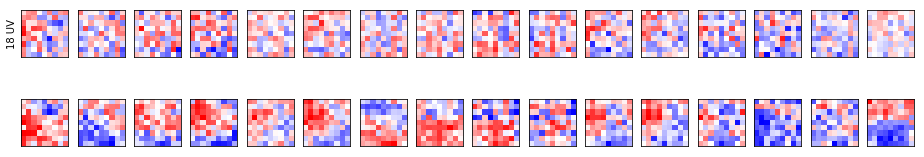

In [25]:
modelnames=np.arange(18,19)
for modelname in modelnames:
    tempmodel= ModelSE3d1_Neu150_ST_Exp()
    tempmodel.load_state_dict(torch.load\
                              ('./out/20200429_ModelSE3d1_Neu150qi_ST_Exp_Ploss_'+str(modelname)+'.pth'))
    tempmodel=tempmodel.to(device_cpu)
    conv1_ss=tempmodel.conv1_ss.cpu().data.numpy() 
    #print (conv1_ss.shape) # (32, 2, 1, 9, 9)
    #nrows=int(conv1_ss.shape[0]/8)
    ncols=conv1_ss.shape[0]
    fig, axes = plt.subplots(nrows=2, ncols=ncols,figsize=(ncols,3))
    for ii in range(ncols): 
        tempmax=np.max(np.abs(conv1_ss[ii]))
        axes[0,ii].imshow(conv1_ss[ii,0,0,:,:],vmin=-tempmax,vmax=tempmax,cmap='bwr')
        if ii==0:
            axes[0,ii].set_ylabel('{:} UV'.format(modelname))
        axes[0,ii].grid(False)#axes[ii,jj].axis('tight')
        axes[0,ii].set_xticks([])
        axes[0,ii].set_yticks([])
        axes[1,ii].imshow(conv1_ss[ii,1,0,:,:],vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[1,ii].grid(False) #axes[ii,jj].axis('tight')
        axes[1,ii].set_xticks([])
        axes[1,ii].set_yticks([])

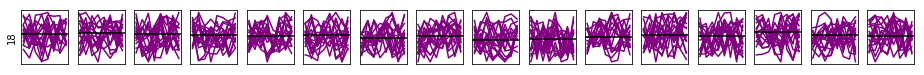

In [26]:
modelnames=np.arange(18,19)
for modelname in modelnames:
    tempmodel= ModelSE3d1_Neu150_ST_Exp()
    tempmodel.load_state_dict(torch.load\
                              ('./out/20200429_ModelSE3d1_Neu150qi_ST_Exp_Ploss_'+str(modelname)+'.pth'))
    tempmodel=tempmodel.to(device_cpu)
    conv1_st=tempmodel.conv1_st.weight.cpu().data.numpy() # shape: (32, 32, 8, 1, 1)
    ncols=conv1_st.shape[0]
    fig, axes = plt.subplots(nrows=1, ncols=ncols,figsize=(ncols,1))
    for ii in range(ncols): 
        #tempmax=np.max(np.abs(conv1_st[ii]))
        for jj in range(conv1_st.shape[1]):
            axes[ii].plot(conv1_st[ii,jj,:].flatten(),color='purple')
        #axes[ii].plot(conv1_st[ii,0,:],color='purple')
        #axes[ii].plot(conv1_st[ii,1,:],color='g')
        axes[ii].axhline(y=0,color='k')
        if ii==0:
            axes[ii].set_ylabel('{:}'.format(modelname))
        axes[ii].set_xticks([])
        axes[ii].set_yticks([])

Overall pearson correlation coefficient:  0.44767198102890465  and p-value:  1.1426015246093172e-202


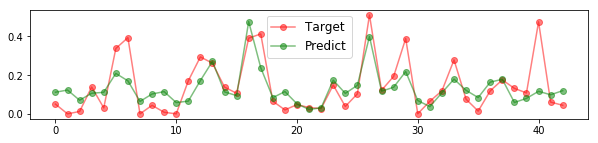

In [29]:
#test model
tempmodel= ModelSE3d1_Neu150_ST_Exp()
tempmodel.load_state_dict(torch.load('./out/20200429_ModelSE3d1_Neu150qi_ST_Exp_Ploss_'+str(18)+'.pth'))
tempmodel=tempmodel.to(device_cpu)
_=model_test(tempmodel,test_loader,device_cpu,use_pad0_sti=False)

torch.cuda.empty_cache()

### after hyperparameter tuning

In [ ]:
EPOCH = 100
LR = 1e-4
seeds  = [1]
alpha1s= [1e1] 
alpha2s= [1e1]
betas  = [1/16] 
modeltrainloss=[]
modelvalloss=[]
for ii in range(len(seeds)):
    modelname=str(ii+1)
    torch.manual_seed(seeds[ii])    # reproducible
    torch.cuda.manual_seed(seeds[ii])
    tempmodel = ModelSE3d1_Neu150_ST_Exp()
    optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
    temp=model_train(tempmodel,train_loader,optimizer,device,EPOCH,Ploss_L2L1_SE_ST,valdata=val_loader,\
                    alpha=alpha1s[0],beta=betas[0],alpha2=alpha2s[0],earlystop=True,verbose=True)
    modeltrainloss.append(temp)
    torch.save(tempmodel.state_dict(),\
                './out/20200429_ModelSE3d1_Neu150qi_ST_Exp_Ploss_seed_'+modelname+'.pth')
    temp=model_val(tempmodel,val_loader,1,device_cpu,loss_mse)
    modelvalloss.append(temp)
    #release gpu memory
    del tempmodel
    torch.cuda.empty_cache()

Overall pearson correlation coefficient:  0.44767198102890465  and p-value:  1.1426015246093172e-202
Overall pearson correlation coefficient:  0.4923317466157764  and p-value:  4.981843538907545e-251
Overall pearson correlation coefficient:  0.5046191316509261  and p-value:  1.2065451720705138e-265
Overall pearson correlation coefficient:  0.480072517279991  and p-value:  4.968814380706482e-237
Overall pearson correlation coefficient:  0.5081045005457137  and p-value:  6.693208301071479e-270
Overall pearson correlation coefficient:  0.4673465662438845  and p-value:  4.3308671572709424e-223
Overall pearson correlation coefficient:  0.4913292435598437  and p-value:  7.306429886852583e-250
Overall pearson correlation coefficient:  0.4948937168811772  and p-value:  5.000951691993433e-254
Overall pearson correlation coefficient:  0.5134410761453627  and p-value:  1.631713627670452e-276
Overall pearson correlation coefficient:  0.5010721676910891  and p-value:  2.3026056289743206e-261
[0.447

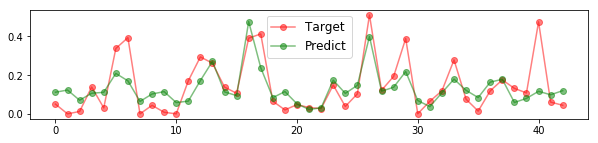

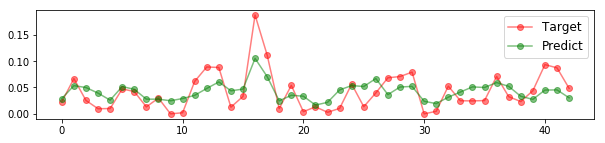

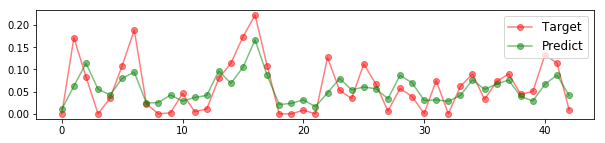

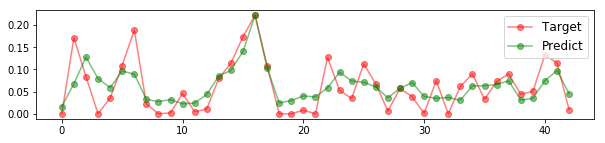

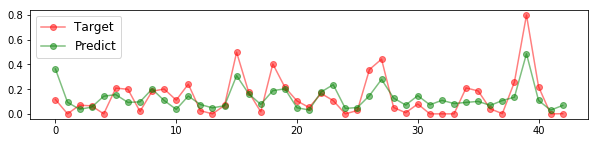

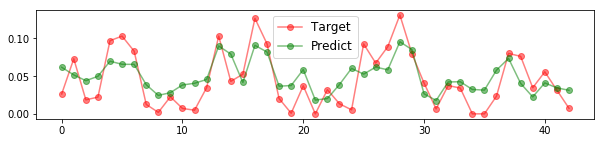

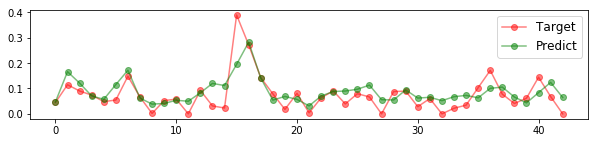

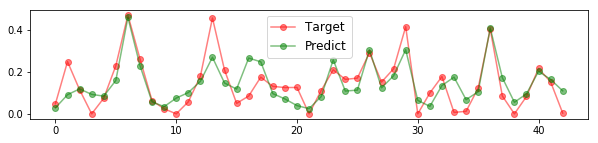

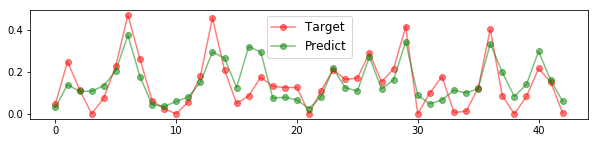

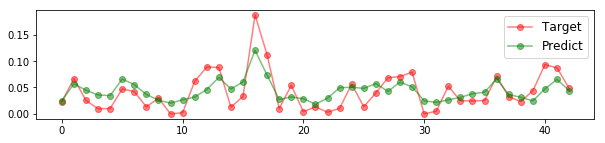

In [24]:
#test model
modeltestloss=[]
for ii in range(10):
    modelname=str(ii+1)
    tempmodel= ModelSE3d1_Neu150_ST_Exp()
    tempmodel.load_state_dict(torch.load('./out/20200429_ModelSE3d1_Neu150qi_ST_Exp_Ploss_seed_'+modelname+'.pth'))
    tempmodel=tempmodel.to(device_cpu)
    CC,_=model_test(tempmodel,test_loader,device_cpu,use_pad0_sti=False)
    modeltestloss.append(CC)

torch.cuda.empty_cache()
modeltestloss=np.array(modeltestloss)
print (modeltestloss)
print (np.mean(modeltestloss))

### RFs and predictions

In [38]:
#save CCs
def model_test_save(model,data,device,use_pad0_sti=True):
    model=model.to(device)
    model=model.eval()
    (x,y)=data
    x=torch.from_numpy(x).float()
    b_x = x.to(device) 
    encoded = model(b_x)
    encoded_np=encoded.cpu().data.numpy()
    if use_pad0_sti==False: # do not use reponses of 0-padding stimulus, here 7 because we use 8 time lags
        encoded_np=encoded_np[7:,:]
        y=y[7:,:]
    testccs=np.zeros((encoded_np.shape[1]))
    for ii in range(encoded_np.shape[1]):
        testccs[ii],testpvalue=pearsonr(encoded_np[:,ii], y[:,ii])
    print (np.median(testccs))
    return testccs
#
tempmodel= ModelSE3d1_Neu150_ST_Exp()
tempmodel.load_state_dict(torch.load('./out/20200429_ModelSE3d1_Neu150qi_ST_Exp_Ploss_seed_6.pth'))
tempmodel=tempmodel.to(device_cpu)
CCs=model_test_save(tempmodel,test_loader,device_cpu,use_pad0_sti=False)
#print (CCs.shape)
#print (CCs)

0.4057628377037983


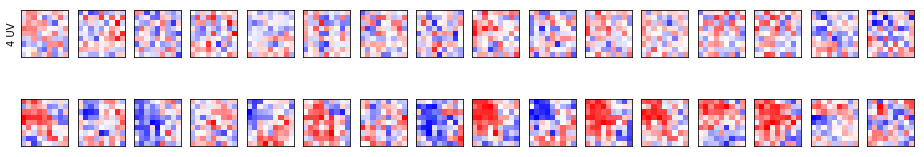

In [22]:
modelnames=np.arange(4,5)
for modelname in modelnames:
    tempmodel= ModelSE3d1_Neu150_ST_Exp()
    tempmodel.load_state_dict(torch.load\
                              ('./out/20200429_ModelSE3d1_Neu150qi_ST_Exp_Ploss_seed_'+str(modelname)+'.pth'))
    tempmodel=tempmodel.to(device_cpu)
    conv1_ss=tempmodel.conv1_ss.cpu().data.numpy() 
    #print (conv1_ss.shape) # (32, 2, 1, 9, 9)
    #nrows=int(conv1_ss.shape[0]/8)
    ncols=conv1_ss.shape[0]
    fig, axes = plt.subplots(nrows=2, ncols=ncols,figsize=(ncols,3))
    for ii in range(ncols): 
        tempmax=np.max(np.abs(conv1_ss[ii]))
        axes[0,ii].imshow(conv1_ss[ii,0,0,:,:],vmin=-tempmax,vmax=tempmax,cmap='bwr')
        if ii==0:
            axes[0,ii].set_ylabel('{:} UV'.format(modelname))
        axes[0,ii].grid(False)#axes[ii,jj].axis('tight')
        axes[0,ii].set_xticks([])
        axes[0,ii].set_yticks([])
        axes[1,ii].imshow(conv1_ss[ii,1,0,:,:],vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[1,ii].grid(False) #axes[ii,jj].axis('tight')
        axes[1,ii].set_xticks([])
        axes[1,ii].set_yticks([])

In [31]:
#Use non-linear least squares to fit a 2d Gaussian function to conv0 and then measure the goodness of fit by r2
conv1_ss_s=[]
r2_s=[]
seeds=np.arange(1,11)
width,height=9,9
for seed in seeds:
    tempmodel= ModelSE3d1_Neu150_ST_Exp()
    tempmodel.load_state_dict(torch.load\
                              ('./out/20200429_ModelSE3d1_Neu150qi_ST_Exp_Ploss_seed_'+str(seed)+'.pth'))
    tempmodel=tempmodel.to(device_cpu)
    conv1_ss=tempmodel.conv1_ss.cpu().data.numpy() #print (conv1_ss.shape) # (16, 2, 1, 9, 9)
    conv1_ss_s.append(conv1_ss)
conv1_ss_s=np.array(conv1_ss_s)
print (conv1_ss_s.shape)
conv1_ss_s=np.reshape(conv1_ss_s,(-1,width*height))
print (conv1_ss_s.shape)
#
for ii in range(len(conv1_ss_s)):
    fit_2dgaussian=Fit_2dGaussian(conv1_ss_s[ii],(width,height))
    fit_2dgaussian.fit()
    r2_s.append(fit_2dgaussian.cal_r2())
r2_s=np.array(r2_s)
print (np.median(r2_s))
print (np.mean(r2_s))

(10, 16, 2, 1, 9, 9)
(320, 81)
0.0
0.16784800065610064


(96, 2, 8, 28, 28)


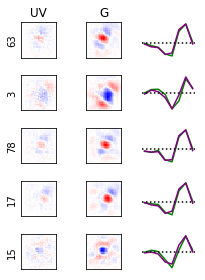

In [23]:
# save svd results of example neuronal RFs
nt = 8 # time lag
ny = 28
nx = 28
dims = [nt, ny, nx]
#
#visualize final layer of model
tempmodel= ModelSE3d1_Neu150_ST_Exp()
tempmodel.load_state_dict(torch.load('./out/20200429_ModelSE3d1_Neu150qi_ST_Exp_Ploss_seed_'+str(6)+'.pth'))
tempmodel=tempmodel.to(device_cpu)
RF_fl=vis_model_fl_3d(tempmodel,device_cpu,(1,2,8,28,28))
RF_fl_np=RF_fl.cpu().data.numpy() #output shape (50,2,28,28)
print (RF_fl_np.shape)
#nums_eg=np.arange(len(RF_fl_np))
#
#plot RFs
nums_eg=[63,3,78,17,15]  #np.arange(len(RF_fl_np)) [63,8,33]
nrows=len(nums_eg)
fig,axes = plt.subplots(nrows=nrows,ncols=3,figsize=(3,int(nrows/1.1)))
for ii in range(nrows):
    [sRF_UV, tRF_UV]=mySVD(RF_fl_np[nums_eg[ii],0], dims)
    [sRF_G, tRF_G]=mySVD(RF_fl_np[nums_eg[ii],1], dims)
    tempmax=np.max(np.abs([sRF_UV,sRF_G]))
    axes[ii,0].imshow(sRF_UV,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,0].set_xticks([])
    axes[ii,0].set_yticks([])
    axes[ii,0].set_ylabel('%d' %(nums_eg[ii]))
    axes[ii,1].imshow(sRF_G,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,1].set_xticks([])
    axes[ii,1].set_yticks([])
    axes[ii,2].plot(tRF_G,color='g',linestyle='-')
    axes[ii,2].plot(tRF_UV,color='purple',linestyle='-')
    axes[ii,2].axhline(y=0,color='k',linestyle=':')
    axes[ii,2].spines['left'].set_visible(False)
    axes[ii,2].spines['bottom'].set_visible(False)
    axes[ii,2].spines['right'].set_visible(False)
    axes[ii,2].spines['top'].set_visible(False)
    axes[ii,2].set_xticks([])
    axes[ii,2].set_yticks([])
axes[0,0].set_title('UV')
axes[0,1].set_title('G')
plt.tight_layout()
#plt.savefig("out_result/20200429_ModelSE3d1_Neu150qi_ST_Exp_Ploss_RFs.svg")

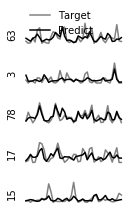

In [24]:
#plot prediction results for example neurons
tempmodel= ModelSE3d1_Neu150_ST_Exp()
tempmodel.load_state_dict(torch.load('./out/20200429_ModelSE3d1_Neu150qi_ST_Exp_Ploss_seed_'+str(6)+'.pth'))
tempmodel=tempmodel.to(device_cpu)
tempmodel=tempmodel.eval()
(x,y)=test_loader
x=torch.from_numpy(x).float()
b_x = x.to(device_cpu) 
with torch.no_grad():
    encoded = tempmodel(b_x)
encoded_np=encoded.cpu().data.numpy()
encoded_np=encoded_np[7:,:] #use_pad0_sti=False
y=y[7:,:] #use_pad0_sti=False
#
nums_eg=[63,3,78,17,15]  #
nrows=len(nums_eg)
#nrows=encoded_np.shape[1]
testccs=np.zeros((nrows))
testpVs=np.zeros((nrows))
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(2,int(nrows/1.5)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,nums_eg[ii]], y[:,nums_eg[ii]])
    testccs[ii]=testcc
    testpVs[ii]=testpvalue
    axes[ii].plot(y[:,nums_eg[ii]],color='gray',linestyle='-',label='Target')
    axes[ii].plot(encoded_np[:,nums_eg[ii]],color='k',linestyle='-',label='Predict')
    if ii == 0:
        axes[ii].legend(loc='best',frameon=False)
        #axes[ii].set_title('UVGnoise_30Hz')
    #axes[ii].set_title('Neuron: {:}, CC: {:.2f}, p: {:.2f}'.format(ii,testcc,testpvalue))
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    #axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(nums_eg[ii]))
plt.tight_layout()

### Rebuttal-whether SI straighten natural movies

(2, 2, 25, 28, 28)


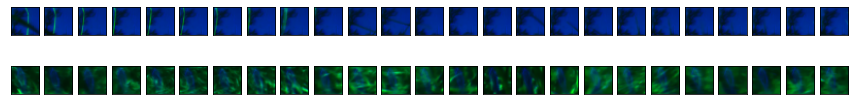

In [23]:
# shape: batch_size x color (UV+G) x time x height x width
snippet_5hz_np=np.load('Data/rebuttal_natural_snippet_5hz_straighten.npy')
print (snippet_5hz_np.shape)
fig, ax =plt.subplots(nrows=2, ncols=25, figsize=(15,2))
for ii in range(2):
    for jj in range(25):
        tempbgr=np.zeros((28,28,3),np.uint8)
        tempbgr[:,:,:2]=np.transpose(snippet_5hz_np[ii,:,jj],(1,2,0))
        ax[ii,jj].imshow(tempbgr[:,:,::-1])
        ax[ii,jj].set_xticks([])
        ax[ii,jj].set_yticks([])

In [25]:
# one seed
class ModelSemiSL3d1_rebu(nn.Module):
    def __init__(self,conv1_st_weight,conv1_st_bias,conv1_ss,conv1_ss_bias,fc1_weight,fc1_bias):
        super().__init__()
        self.numoffea=16 #number of features
        self.sizeoffea=20*20 #size of feature
        self.numofneuron=96 #number of neurons
        #spatial kernel, self.kernel_size=9 #odd number
        self.conv1_ss=nn.Parameter(torch.zeros(self.numoffea,2,1,9,9))
        std=1. / np.sqrt(2*1*9*9)
        self.conv1_ss.data.uniform_(-std*0.1, std*0.1)
        self.conv1_ss_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_ss_bias.data.uniform_(-std, std)
        #temporal kernel
        self.conv1_st=nn.Conv3d(self.numoffea,self.numoffea,kernel_size=(8,1,1),stride=1)
        #fc layer
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)
        #
        self.conv1_st.weight.data.copy_(conv1_st_weight.clone().detach())
        self.conv1_st.bias.data.copy_(conv1_st_bias.clone().detach())
        self.conv1_ss.data.copy_(conv1_ss.clone().detach())
        self.conv1_ss_bias.data.copy_(conv1_ss_bias.clone().detach())
        self.fc1.weight.data.copy_(fc1_weight.clone().detach())
        self.fc1.bias.data.copy_(fc1_bias.clone().detach())
    #
    def forward(self, x):
        encoded = F.conv3d(x, self.conv1_ss, bias=self.conv1_ss_bias,stride=1,padding=(0,0,0))
        encoded = self.conv1_st(encoded)
        #encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        #encoded = torch.exp(self.fc1(encoded))
        return encoded
    
# tempmodel= ModelSemiSL3d1()
# tempmodel.load_state_dict(torch.load\
#                     ('./out/20200429_v4_ModelSemiSL3d1_dorsal_upandlow_seed_6_weight_9'+'.pth'))
tempmodel= ModelSE3d1_Neu150_ST_Exp()
tempmodel.load_state_dict(torch.load('./out/20200429_ModelSE3d1_Neu150qi_ST_Exp_Ploss_seed_'+str(6)+'.pth'))
tempmodel=tempmodel.to(device_cpu)
conv1_st_weight  =tempmodel.conv1_st.weight.data.clone().detach()
conv1_st_bias  =tempmodel.conv1_st.bias.data.clone().detach()
conv1_ss  =tempmodel.conv1_ss.data.clone().detach()
conv1_ss_bias   =tempmodel.conv1_ss_bias.data.clone().detach()
fc1_weight=tempmodel.fc1.weight.data.clone().detach()
fc1_bias  =tempmodel.fc1.bias.data.clone().detach()

tempmodel= ModelSemiSL3d1_rebu(conv1_st_weight,conv1_st_bias,conv1_ss,conv1_ss_bias,fc1_weight,fc1_bias)
tempmodel=tempmodel.to(device_cpu)
tempmodel=tempmodel.eval()
z=snippet_5hz_np/255.0
sky_bg_mean_f = [0.19641674, 0.20930869]
z[:,0,:,:,:]=z[:,0,:,:,:]-sky_bg_mean_f[0]
z[:,1,:,:,:]=z[:,1,:,:,:]-sky_bg_mean_f[1]
b_z = torch.from_numpy(z).float().to(device_cpu)
with torch.no_grad():
    encoded = tempmodel(b_z)
encoded_np=encoded.cpu().data.numpy()
print (encoded_np.shape)

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)
def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

curvature = []
for ii in range(encoded_np.shape[0]):
    temps=np.diff(np.transpose(encoded_np[ii], (1,0,2,3)).reshape(18,-1), axis=0)
    temp_c =[]
    for ii in range(len(temps)-1):
        temp_c.append(np.rad2deg(angle_between(temps[ii], temps[ii+1])))
    curvature.append(np.mean(np.array(temp_c)))
    print (temp_c, curvature)

(2, 16, 18, 20, 20)
[121.22029225511389, 119.65771453023493, 112.06605976278094, 112.23568548278485, 92.21254097816532, 109.66388795213336, 105.48985750124223, 101.8207804487252, 106.91581062149656, 97.87603031520368, 101.4747696596555, 98.52589538076451, 102.07619432864199, 101.76795029264484, 104.89788173906871, 99.27121792419523] [105.44828557330322]
[106.30832082279397, 105.17735586965482, 101.77670809899867, 105.88821479008074, 99.42964466127601, 102.8815654468203, 104.70023709102581, 110.02050834291278, 104.45953002281382, 103.2956463953819, 104.91956144235431, 107.73523002520248, 107.5453938964544, 100.49732639031777, 99.03898878955366, 93.85714409875213] [105.44828557330322, 103.5957110115246]


In [26]:
# 10 seeds
curvatures=np.zeros((10,2)) # 10 seeds, 2 snippets (upper+lower)
for jj in range(10):
#     tempmodel= ModelSemiSL3d1()
#     tempmodel.load_state_dict(torch.load\
#                         ('./out/20200429_v4_ModelSemiSL3d1_dorsal_upandlow_seed_'+str(jj+1)+'_weight_9'+'.pth'))
    tempmodel= ModelSE3d1_Neu150_ST_Exp()
    tempmodel.load_state_dict(torch.load('./out/20200429_ModelSE3d1_Neu150qi_ST_Exp_Ploss_seed_'+str(jj+1)+'.pth'))
    tempmodel=tempmodel.to(device_cpu)
    conv1_st_weight  =tempmodel.conv1_st.weight.data.clone().detach()
    conv1_st_bias  =tempmodel.conv1_st.bias.data.clone().detach()
    conv1_ss  =tempmodel.conv1_ss.data.clone().detach()
    conv1_ss_bias   =tempmodel.conv1_ss_bias.data.clone().detach()
    fc1_weight=tempmodel.fc1.weight.data.clone().detach()
    fc1_bias  =tempmodel.fc1.bias.data.clone().detach()
    #
    tempmodel= ModelSemiSL3d1_rebu(conv1_st_weight,conv1_st_bias,conv1_ss,conv1_ss_bias,fc1_weight,fc1_bias)
    tempmodel=tempmodel.to(device_cpu)
    tempmodel=tempmodel.eval()
    z=snippet_5hz_np/255.0
    sky_bg_mean_f = [0.19641674, 0.20930869]
    z[:,0,:,:,:]=z[:,0,:,:,:]-sky_bg_mean_f[0]
    z[:,1,:,:,:]=z[:,1,:,:,:]-sky_bg_mean_f[1]
    b_z = torch.from_numpy(z).float().to(device_cpu)
    with torch.no_grad():
        encoded = tempmodel(b_z)
    del tempmodel
    encoded_np=encoded.cpu().data.numpy()
    #
    curvature = []
    for ii in range(encoded_np.shape[0]):
        temps=np.diff(np.transpose(encoded_np[ii], (1,0,2,3)).reshape(18,-1), axis=0)
        temp_c =[]
        for ii in range(len(temps)-1):
            temp_c.append(np.rad2deg(angle_between(temps[ii], temps[ii+1])))
        curvature.append(np.mean(np.array(temp_c)))
    curvatures[jj,:] = np.array(curvature)
#
print (curvatures)

[[100.3883093   97.49892149]
 [103.48162961 100.89979022]
 [107.74880575  98.1905688 ]
 [ 97.03641315  90.55972014]
 [105.66612146  99.02948828]
 [105.44828557 103.59571101]
 [ 99.83135573  91.9629914 ]
 [ 98.68690275  91.10503438]
 [100.54395544  93.81373071]
 [105.45313183 102.19745953]]


In [28]:
#np.save('out_result/rebuttal_straighten_curvature_si.npy', curvatures)